****Here we use a simple k-means clustering to show the neurons that fire together

In [1]:
import os
from skimage.io import imread
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#MAX_IMAGES = 800
DOWNSCALE_FACTOR = 2

flo_image_1 = np.load('../input/flo_image_1.npz')
flo_image_2 = np.load('../input/flo_image_2.npz')
image_ids = np.concatenate([flo_image_1['image_ids'], flo_image_2['image_ids']])
image_dict = dict(zip(np.concatenate([flo_image_1['image_ids'], flo_image_2['image_ids']]), 
                      np.concatenate([flo_image_1['image_stack'], flo_image_2['image_stack']])
                      [:, ::DOWNSCALE_FACTOR, ::DOWNSCALE_FACTOR]))
print('Loaded',len(image_dict), 'images')

Loaded 1685 images


In [3]:
time_df = pd.read_csv('../input/data141110.csv')
time_df['path'] = time_df['Image.No.'].map(lambda x: "141110A3.%04d" % (x))
time_df['loaded'] = time_df['path'].map(lambda x: x in image_dict)
valid_time_df = time_df.query('loaded')
valid_time_df.sample(3)

,Image.No.,Frame.No,Time.hrs.,path,loaded
1468,1518,1469,150.416306,141110A3.1518,True
318,368,319,35.416306,141110A3.0368,True
569,619,570,60.516306,141110A3.0619,True


# Assemble the data
Here we assemble the data into a 3D stack ordered by time for further analysis

In [4]:
ordered_im_stack = np.stack([image_dict[c_path] for c_path in valid_time_df.sort_values('Time.hrs.')['path'].values],0)
#del image_dict, flo_image_1, flo_image_2

# Show an montage overview of the whole stack

In [5]:
#from skimage.util.montage import montage2d
#plt.imshow(montage2d(ordered_im_stack[::4]))

In [6]:
# unwrap the pixel positions so we have just the time observations
time_vec = ordered_im_stack.reshape(ordered_im_stack.shape[0], -1)

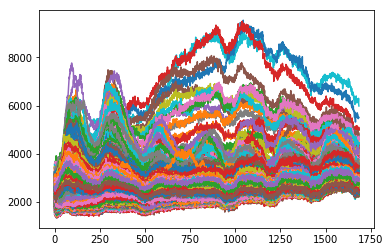

In [7]:
# show the various time courses
_ = plt.plot(time_vec[:,::100])

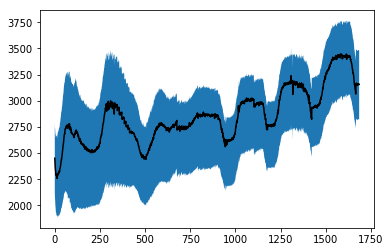

In [8]:
x = np.linspace(0, len(time_vec), len(time_vec))
y = np.mean(time_vec,1)
pos_error = np.quantile(time_vec, 0.75, 1)
neg_error = np.quantile(time_vec, 0.25, 1)

plt.plot(x, y, 'k-')
plt.fill_between(x, neg_error, pos_error)

# K-Means Clustering
Here we cluster the temporal data by time to make a better representation of the image

In [9]:
from sklearn.cluster import KMeans
n_kmc4 = KMeans(n_clusters = 4)
n_kmc3 = KMeans(n_clusters = 3)

In [10]:
%%time
# apply the kmeans clustering
n_kmc4.fit(time_vec.T)
n_kmc3.fit(time_vec.T)

CPU times: user 2min 41s, sys: 42.7 s, total: 3min 23s
Wall time: 2min 37s


## Spectral Clustering

In [11]:
#from sklearn.cluster import DBSCAN
#n_dbscan = DBSCAN(eps=0.0001, min_samples=1000).fit(time_vec.T)


In [12]:
#np.unique(n_dbscan.labels_)

In [13]:
#from sklearn.cluster import SpectralClustering
#n_sc = SpectralClustering(n_clusters=3)

In [14]:
#n_sc.fit(time_vec.T)

# Show Clusters
Here we show the clusters as a new image, the regions colored the same, have the same time-course of activation and thus fire together. 

In [15]:
def show_clusters(algo):
    cluster_vec = algo.predict(time_vec.T)
    cluster_img = cluster_vec.reshape(ordered_im_stack.shape[1:])
    fig, ax1 = plt.subplots(1,1)
    ax1.imshow(cluster_img, cmap = 'rainbow')
    ax1.set_title('Cluster Image')
    return cluster_vec, cluster_img

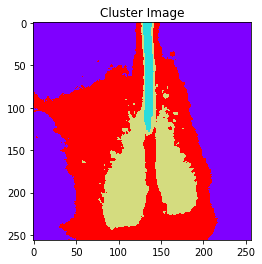

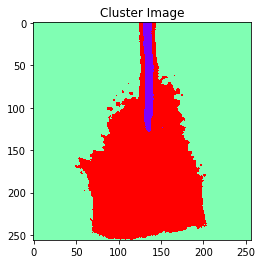

In [16]:
cluster_vec4, cluster_img4 = show_clusters(n_kmc4)
cluster_vec3, cluster_img3 = show_clusters(n_kmc3)

## Time Behavior of Each Cluster
Here we take each cluster and show the temporal behavior. This lets us show more clearly the differences between groups and see if there are groups which are phase-shifted from others which might indicate a sequential firing pattern

In [17]:
cluster_vec4[61440:] = 4
print(np.unique(cluster_vec4, return_counts=True))


(array([0, 1, 2, 3, 4], dtype=int32), array([30880,  1196,  9607, 19757,  4096]))


In [25]:
cluster_4_names = ["Ventricle", "Outer SCN", "Inner SCN", "Surrounding", "Optic Chiasm"]
cluster_3_names = ["Ventricle", "Surrounding", "SCN"]
cluster_4_means = [np.mean(time_vec[:,cluster_vec4 == idx],1) for idx in range(5)]
cluster_3_means = [np.mean(time_vec[:,cluster_vec3 == idx],1) for idx in range(3)]
cluster_4_pos = [np.quantile(time_vec[:,cluster_vec4 == idx], 0.75, 1) for idx in range(5)]
cluster_4_neg = [np.quantile(time_vec[:,cluster_vec4 == idx], 0.25, 1)  for idx in range(5)]
cluster_3_pos = [np.quantile(time_vec[:,cluster_vec3 == idx], 0.75, 1) for idx in range(3)]
cluster_3_neg = [np.quantile(time_vec[:,cluster_vec3 == idx], 0.25, 1)  for idx in range(3)]

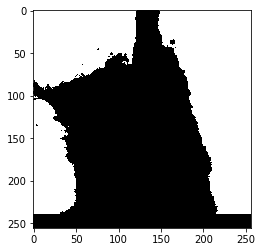

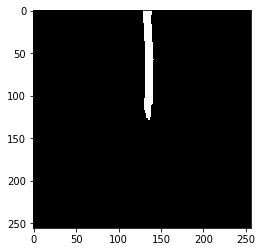

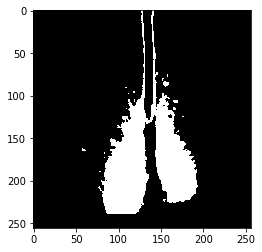

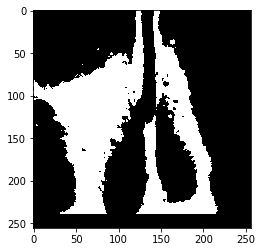

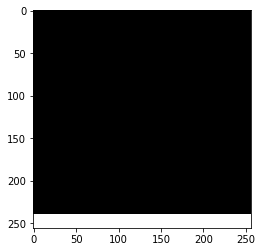

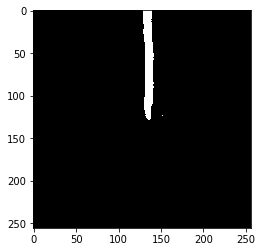

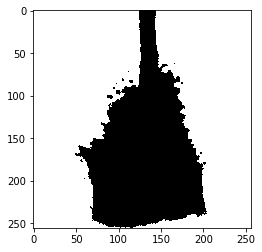

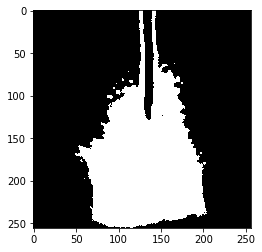

In [19]:
for idx in range(5):
    plt.imshow(cluster_img4 == idx, cmap = 'bone')
    plt.show()
for idx in range(3):
    plt.imshow(cluster_img3 == idx, cmap = 'bone')
    plt.show()

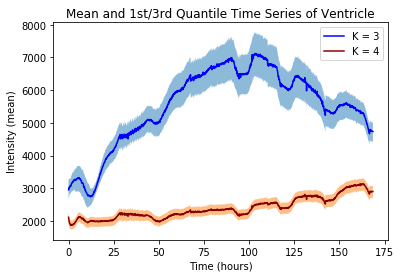

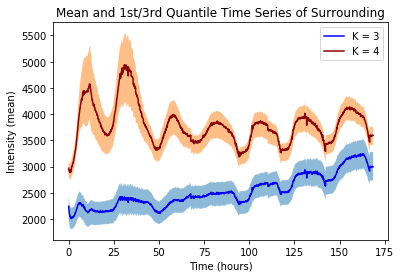

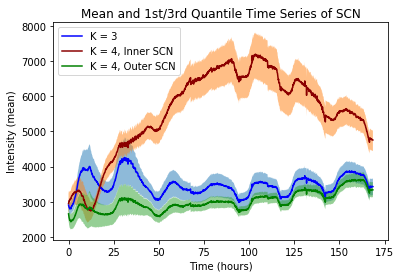

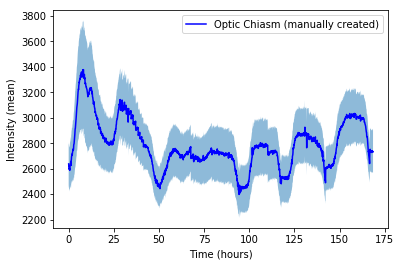

In [26]:
ALPHA_value = 0.5
for idx in range(3):
    x = np.linspace(0, len(time_vec[:,cluster_vec3 == idx])/10, len(time_vec[:,cluster_vec3 == idx]))
    y = cluster_3_means[idx]
    pos_error = cluster_3_pos[idx]
    neg_error = cluster_3_neg[idx]
    plt.plot(x, y, 'k-', color='blue', label='K = 3')
    plt.fill_between(x, neg_error, pos_error, alpha=ALPHA_value)
    plt.title('Mean and 1st/3rd Quantile Time Series of {}'.format(cluster_3_names[idx]))
    
    if idx == 0:
        idx = 0
        x = np.linspace(0, len(time_vec[:,cluster_vec4 == idx])/10, len(time_vec[:,cluster_vec4 == idx]))
        y = cluster_4_means[idx]
        pos_error = cluster_4_pos[idx]
        neg_error = cluster_4_neg[idx]
        plt.plot(x, y, 'k-', color="darkred", label="K = 4")
        plt.fill_between(x, neg_error, pos_error, alpha=ALPHA_value)
    elif idx == 1:
        idx = 2
        x = np.linspace(0, len(time_vec[:,cluster_vec4 == idx])/10, len(time_vec[:,cluster_vec4 == idx]))
        y = cluster_4_means[idx]
        pos_error = cluster_4_pos[idx]
        neg_error = cluster_4_neg[idx]
        plt.plot(x, y, 'k-', color="darkred", label="K = 4")
        plt.fill_between(x, neg_error, pos_error, alpha=ALPHA_value)
    elif idx == 2:
        for ix in [1, 3]:
            x = np.linspace(0, len(time_vec[:,cluster_vec4 == ix])/10, len(time_vec[:,cluster_vec4 == ix]))
            y = cluster_4_means[ix]
            pos_error = cluster_4_pos[ix]
            neg_error = cluster_4_neg[ix]
            if ix == 1:
                plt.plot(x, y, 'k-', color='darkred', label="K = 4, Inner SCN")
                plt.fill_between(x, neg_error, pos_error, alpha=ALPHA_value)
            elif ix == 3:
                plt.plot(x, y, 'k-', color='green', label="K = 4, Outer SCN")
                plt.fill_between(x, neg_error, pos_error, alpha=ALPHA_value)
    
    plt.xlabel('Time (hours)')
    plt.ylabel('Intensity (mean)')
    plt.legend()
    plt.show()
idx = 4
x = np.linspace(0, len(time_vec[:,cluster_vec4 == idx])/10, len(time_vec[:,cluster_vec4 == idx]))
y = cluster_4_means[idx]
pos_error = cluster_4_pos[idx]
neg_error = cluster_4_neg[idx]
plt.plot(x, y, 'k-', color='blue', label="Optic Chiasm (manually created)")
plt.fill_between(x, neg_error, pos_error, alpha=ALPHA_value)
plt.xlabel('Time (hours)')
plt.ylabel('Intensity (mean)')
plt.legend()
plt.show()

In [ ]:
cluster_dict = {}
cluster_ids = np.unique(cluster_vec)
fig, m_axs = plt.subplots(len(cluster_ids), 2, figsize = (10, len(cluster_ids)*6))
for (im_ax, c_ax) , idx in zip(m_axs, cluster_ids):
    im_ax.imshow(cluster_img == idx, cmap = 'bone')
    im_ax.axis('off')
    c_ax.set_title('Image of Cluster {}'.format(idx))
    c_ax.plot(
        valid_time_df['Time.hrs.'],
        np.mean(time_vec[:,cluster_vec == idx],1))
    c_ax.set_title('Mean Time Series of Cluster {}'.format(idx))
    c_ax.set_xlabel('Time (hours)')
    c_ax.set_ylabel('Intensity (mean)')
    cluster_dict[idx] = np.mean(time_vec[:,cluster_vec == idx],1)

In [ ]:
cluster_ids = np.unique(cluster_vec)
fig, m_axs = plt.subplots(len(cluster_ids), 2, figsize = (10, len(cluster_ids)*6))
for (im_ax, c_ax) , idx in zip(m_axs, cluster_ids):
    im_ax.imshow(cluster_img == idx, cmap = 'bone')
    im_ax.axis('off')
    c_ax.set_title('Image of Cluster {}'.format(idx))
    
    x = np.linspace(0, len(time_vec[:,cluster_vec == idx]), len(time_vec[:,cluster_vec == idx]))
    y = np.mean(time_vec[:,cluster_vec == idx],1)
    pos_error = np.quantile(time_vec[:,cluster_vec == idx], 0.75, 1)
    neg_error = np.quantile(time_vec[:,cluster_vec == idx], 0.25, 1)

    c_ax.plot(x, y, 'k-')
    c_ax.fill_between(x, neg_error, pos_error)
    c_ax.set_title('Mean Time Series of Cluster {}'.format(idx))
    c_ax.set_xlabel('Time (hours)')
    c_ax.set_ylabel('Intensity (mean)')

In [ ]:
np.savetxt('clusters_4means.txt', cluster_vec, fmt='%d')
cluster_vec_loaded = np.loadtxt('clusters_4means.txt', dtype=int)

cluster_vec_loaded

In [ ]:
for i in range(4):
    np.savetxt('cluster_dict_'+str(i)+'.txt', cluster_dict[i], fmt='%d')
    print(np.loadtxt('cluster_dict_'+str(i)+'.txt', dtype=int)
         )

In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.filters import uniform_filter # smoothing images
from sklearn.linear_model import LinearRegression

In [ ]:
# load csv
data = np.loadtxt('../input/data141110.csv', delimiter=',', skiprows=1)
image_ids = np.concatenate([flo_image_1['image_ids'], flo_image_2['image_ids']])
images = np.concatenate([flo_image_1['image_stack'], flo_image_2['image_stack']])

In [ ]:
# reshaping each array (to make them work with sklearn)
# -1 is unknown dimension which numpy has to figure out, 1 is the other
image_no=data[:,0].reshape(-1,1)
frame_no=data[:,1].reshape(-1,1)
time_hrs=data[:,2].reshape(-1,1)
# check what python figured out as dimension for -1?
nb_images = data.shape[0]
nb_images

In [ ]:
# DETERMINE PERIODS
# variation of light-insensity in suprachiasmatic nuclei (two bright ovals), expression varies in day-night cycle

#1. Durchschnittsintensität aller Werte in einem Bild, für jedes
# wenn Nuclei mehr aufleuchten -> höhere Intensität gesamt
# -> definitiv periodisches aufleuchten durch auf und ab

# mean intensity over time over whole image for each image 
# and plot against time
mean_values = np.mean(images, axis=(1,2))
# linear regression
model = LinearRegression()
# fit model
model.fit(time_hrs, mean_values)
# predict model
mean_linear = model.predict(time_hrs)
# plot intensity against time, prediction against mean-values
plt.plot(time_hrs, model.predict(time_hrs), 'r')
plt.plot(time_hrs, mean_values, 'b')

# calculate norm-values for later
norm_values = mean_values - mean_linear

In [ ]:
cluster_img

In [ ]:
all_pics = np.concatenate([flo_image_1['image_stack'], flo_image_2['image_stack']])[:, ::DOWNSCALE_FACTOR, ::DOWNSCALE_FACTOR]


In [ ]:
print(all_pics.shape)
cluster_0 = all_pics[:, cluster_img == 0]

In [ ]:
def remove_linear_trend(time_series):
    x_axis = np.arange(len(time_series)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(x_axis, time_series)
    return time_series - model.predict(x_axis)

def filtered_acorr(time_series, high_pass=None, unbiased=True):
    """
    high_pass is a short 1D float array, 
    by which the low-frequency amplitudes are multiplied,
    e.g. high_pass = [0,0,0,0,0,0]
    """
    N = len(time_series)
    norm_values = remove_linear_trend(time_series)
    spectrum = np.fft.fft(norm_values, n=2*N)
    if high_pass is not None:
        spectrum[0] *= high_pass[0]
        for i in range(len(high_pass)):
            spectrum[i] *= high_pass[i]
            spectrum[-i] *= high_pass[i]
    acorr = np.real(np.fft.ifft(spectrum * np.conj(spectrum))[:N])
    if unbiased:
        return acorr / (N - np.arange(N))
    else:
        return acorr / N
    

def get_period(acorr):
    """
    Returns the index with largest acorr value, 
    after the first zero crossing.
    There are of course more sophisticated methods of doing this.
    """
    negative_periods = np.where(acorr <= 0.0)
    if negative_periods[0].size == 0:
        return 0
    first_zero = np.min(negative_periods)
    return first_zero + np.argmax(acorr[first_zero:])


def get_grid_periods(images, box_size, max_period=300, high_pass=np.zeros((10,)), unbiased=False):
    """
    periods, acorrs = get_grid_periods(images, box_size, max_period=300, 
                                    high_pass=np.zeros((10,)), unbiased=False)
    Divides the image domain into small boxes of size box_size = (h,w) and computes
    the period over each of these small boxes."""
    h,w = box_size
    rows = images.shape[1] // h
    cols = images.shape[2] // w
    acorrs = np.empty((rows, cols, max_period), dtype = "float32")
    periods = np.empty((rows,cols, ), dtype = "int")
    for i in range(rows):
        for j in range(cols):
            time_series = np.mean(images[:, i*h:(i+1)*h, j*w:(j+1)*w], axis=(1,2))
            acorrs[i ,j] = filtered_acorr(time_series, high_pass = high_pass, 
                                          unbiased=unbiased)[:max_period]
            periods[i ,j] = get_period(acorrs[i, j])
    return periods, acorrs

periods, acorrs = get_grid_periods(images, (32, 32), max_period=1000, unbiased=False)
#plt.imshow(periods, cmap='hot')
#print(periods)

In [ ]:
all_acorrs = []
all_periods = []
for idx in range(4):
    curr_cluster = all_pics[:, cluster_img == idx]
    max_period=1000
    unbiased=False
    high_pass=np.zeros((10,))
    cluster_acorr = np.empty((curr_cluster.shape[1], max_period), dtype = "float32")
    cluster_periods = np.empty((curr_cluster.shape[1], ), dtype = "int")
    for i in range(curr_cluster.shape[1]):
        time_series = curr_cluster[:, i]
        cluster_acorr[i] = filtered_acorr(time_series, high_pass = high_pass, 
                                      unbiased=unbiased)[:max_period]
        cluster_periods[i] = get_period(cluster_acorr[i])
    all_acorrs.append(cluster_acorr)
    all_periods.append(cluster_periods)

In [ ]:
for per in all_periods:
    print(np.mean(per))

In [ ]:
import operator
for periods in all_periods:
    # to quantify the amount of variation in data
    # low dev = data points tend to be close to mean (expected value)
    # high dev = data points are spread out over wider range
    per_dev = np.std(periods)
    print(per_dev) #eig dann 0.5? means low?

    #24.2 is highest occurence (vorkommen)
    #expected value
    per_mean = np.mean(periods)/10
    print(per_mean)

    #cnt_all_val = len(norm_values)
    #print(cnt_all_val)
    period_ten = periods/10

    print(period_ten)
    #often_values = np.array(np.unique(periods, return_counts=True)).T
    
    # compute standard deviation
    #periods_st_deviation = np.std(mean_values/10)#
    periods_st_deviation = np.std(period_ten)
    print(periods_st_deviation)

    print()
    #low result -> data points all close to mean -> periodic

In [ ]:
for idx in range(4):
    # FFT =
    # fast way to get dominant period/frequency is FFT
    # convertion of signal in time spectrum to a frequency spectrum
    # This method (FFT) makes use of the fact that every non-linear function 
    # can be represented as a sum of (infinite) sine waves


    #take frequency that gives maximum value in graph

    # mean intensity over time over whole image for each image 
    # and plot against time
    mean_values = np.mean(all_pics[:, cluster_img == idx], axis=(1))
    print(mean_values.shape)
    # linear regression
    model = LinearRegression()
    # fit model
    model.fit(time_hrs, mean_values)
    # predict model
    mean_linear = model.predict(time_hrs)
    # plot intensity against time, prediction against mean-values
    plt.plot(time_hrs, model.predict(time_hrs), 'r')
    plt.plot(time_hrs, mean_values, 'b')

    # calculate norm-values for later
    norm_values = mean_values - mean_linear
    
    # why norm_values and not mean_values?
    # rfft calculates the fft in data for real input
    spectrum = np.fft.rfft(norm_values)

    # ten image frames per hour
    # fftfreq computes frequencies associated with FFT components
    # returns an array giving the frequencies of corresponding elements
    # x-axis !!
    freq = np.fft.rfftfreq(len(norm_values), 1/10)#data size + time steps in x-axis in ()

    max_freq1 = 1.0 / freq #warum 3 bis ende?? Andere Werte kommen raus
    # does it take one of the peaks and not the highest?
    #max_freq1 = 1.0 / freq

    #use absolute value of fft
    max_freq2 = abs(spectrum[:len(freq)]) #warum 3??
    #takes another peak if we take whole length
    #max_freq2 = abs(spectrum)

    plt.plot(max_freq1, max_freq2)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('spectrum [V RMS]')#?
    plt.title('Regularity with Power Spectrum');
    plt.show()